# Scoreboard Training


_November 8, 2019_

#### Data Structure

| Label | Class |
|-------|-------|
|   0   |   0   |
|   1   |   1   |
|   2   |   2   |
|   3   |   3   |
|   4   |   4   |
|   5   |   5   |
|   6   |   6   |
|   7   |   7   |
|   8   |   8   |
|   9   |   9   |
|   x   |  None |


#### Jupyter Style


  Jupter Theme set to `monokai`
  * `jt -t monokai`


  Set Code Font to Firacode, font-size 11
  * `jt -t monokai -f firacode -fs 11`


  Set Notebook Font to Open Sans, notebook font-size 11
  * `jt -t monokai -nf opensans -nfs 11`


  Set Text/MD Font to , size 
  * `jt -t monokai -tfs 11`

## Setup
---

### Bash Commands

In [1]:
!pip install --upgrade pip
# !pip install tensorflow
# !pip install loguru

#### Install Widgets & Extensions ####
# !pip install ipywidgets
# !pip install jupyter_contrib_nbextensions
# !pip install jupyter_nbextensions_configurator
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter nbextensions_configurator enable --user
# !jupyter nbextension enable Scratchpad

Requirement already up-to-date: pip in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages (19.3.1)


### Imports

In [2]:
# Helper Libraries
# =================================
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display

# Tensorflow
# =================================
import tensorflow as tf

print(f"Tensorflow Version: {tf.__version__}")

Tensorflow Version: 2.0.0


### Helper Functions

In [3]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [5]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

After downloading (218MB), you should now have a copy of the flower photos available.

The directory contains 5 sub-directories, one per class:

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips'],
      dtype='<U10')

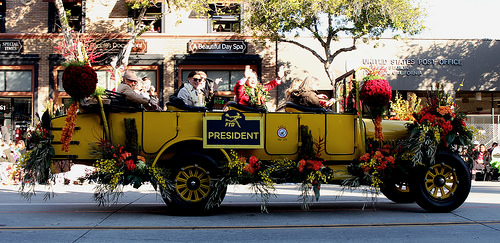

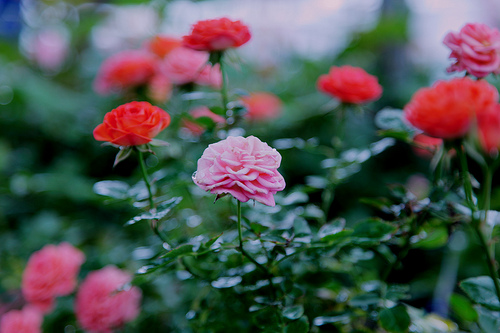

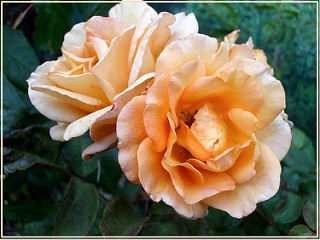

In [8]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [9]:
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has two downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a tf.data.Dataset first create a dataset of the file paths:


In [11]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [12]:
for f in list_ds.take(5):
  print(f.numpy())

b'/Users/randycounsman/.keras/datasets/flower_photos/dandelion/5676682203_70d797f760.jpg'
b'/Users/randycounsman/.keras/datasets/flower_photos/sunflowers/4895719476_bd3b6bd6fd_n.jpg'
b'/Users/randycounsman/.keras/datasets/flower_photos/dandelion/6985099958_5249a4688b.jpg'
b'/Users/randycounsman/.keras/datasets/flower_photos/sunflowers/3154932076_eff5c38231_n.jpg'
b'/Users/randycounsman/.keras/datasets/flower_photos/roses/8524505682_bda885af3a_n.jpg'


Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [13]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [14]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [15]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [16]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [17]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False False]


### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [18]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [19]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

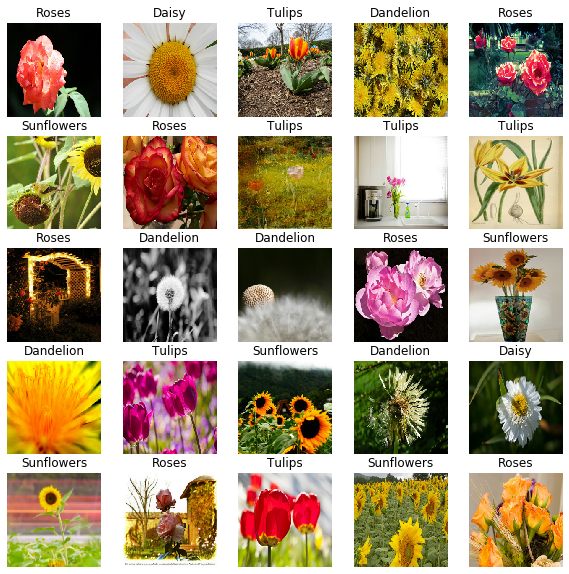

In [20]:
show_batch(image_batch.numpy(), label_batch.numpy())